# LSTM

In [19]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [51]:
crypto = pd.read_csv("consolidated_coin_data.csv", parse_dates=['Date'])

In [52]:
crypto_btc = crypto[crypto['Currency'] == "bitcoin"]

In [53]:
crypto_btc.head()

,Currency,Date,Open,High,Low,Close,Volume,Market Cap
7236,bitcoin,2019-12-04,7320.13,7539.78,7170.92,7252.03,21664240918,1.311430e+11
7237,bitcoin,2019-12-03,7323.98,7418.86,7229.36,7320.15,14797485769,1.323600e+11
7238,bitcoin,2019-12-02,7424.04,7474.82,7233.40,7321.99,17082040706,1.323790e+11
7239,bitcoin,2019-12-01,7571.62,7571.62,7291.34,7424.29,18720708479,1.342150e+11
7240,bitcoin,2019-11-30,7764.06,7836.10,7515.85,7569.63,17158194786,1.368290e+11


## 1. Bitcoin

In [119]:
crypto_btc = crypto_btc.sort_values('Date')

In [120]:
crypto_btc.shape

(2412, 8)

''

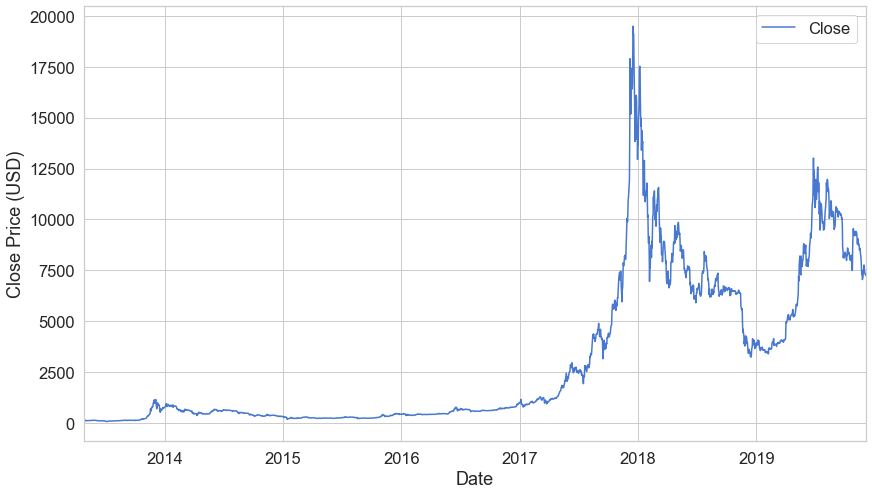

In [121]:
ax = crypto_btc.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
;


In [122]:
scaler = MinMaxScaler()
close_price = crypto_btc.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [123]:
scaled_close

array([[0.00338567],
       [0.00391735],
       [0.0036322 ],
       ...,
       [0.37333734],
       [0.37324264],
       [0.36973653]])

In [124]:
np.isnan(scaled_close).any()

False

In [125]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [126]:
scaled_close = scaled_close.reshape(-1, 1)

In [127]:
np.isnan(scaled_close).any()

False

### Preprocessing

In [128]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [129]:
X_train.shape

(2196, 99, 1)

In [130]:
y_train.shape

(2196, 1)

In [131]:
X_test.shape

(116, 99, 1)

In [132]:
y_test.shape

(116, 1)

### Model

In [133]:
#The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, 
#and an output layer that makes a single value prediction. 
#The default sigmoid activation function is used for the LSTM blocks. 
#The network is trained for 15 epochs and a batch size of 32 is used.


model = Sequential()
#We add the LSTM layer with the following arguments:
#100 units which is the dimensionality of the output space
#return_sequences=True which determines whether to return the last output in the output sequence,
#or the full sequence
#input_shape as the shape of our training set.
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#We add the LSTM layer and later add a few Dropout layers to prevent overfitting. 

model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [134]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

### Epoch 15

In [135]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/15
2196/2196 [==============================] - 25s 11ms/sample - loss: 0.0064
Epoch 2/15
2196/2196 [==============================] - 27s 12ms/sample - loss: 0.0025
Epoch 3/15
2196/2196 [==============================] - 23s 11ms/sample - loss: 0.0020
Epoch 4/15
2196/2196 [==============================] - 23s 11ms/sample - loss: 0.0017
Epoch 5/15
2196/2196 [==============================] - 23s 11ms/sample - loss: 0.0017
Epoch 6/15
2196/2196 [==============================] - 21s 10ms/sample - loss: 0.0017
Epoch 7/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0016
Epoch 8/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0014
Epoch 9/15
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0011
Epoch 10/15
2196/2196 [==============================] - 24s 11ms/sample - loss: 0.0013
Epoch 11/15
2196/2196 [==============================] - 25s 11ms/sample - loss: 0.0011
Epoch 12/15
2196/2196 

In [136]:
model.evaluate(X_test, y_test)

116/116 [==============================] - 1s 12ms/sample - loss: 0.0014


0.0014495909824196634

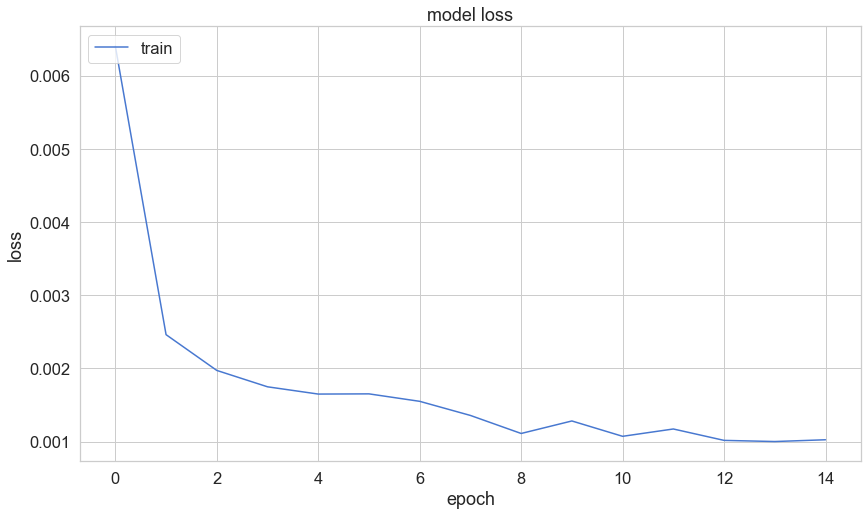

In [137]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

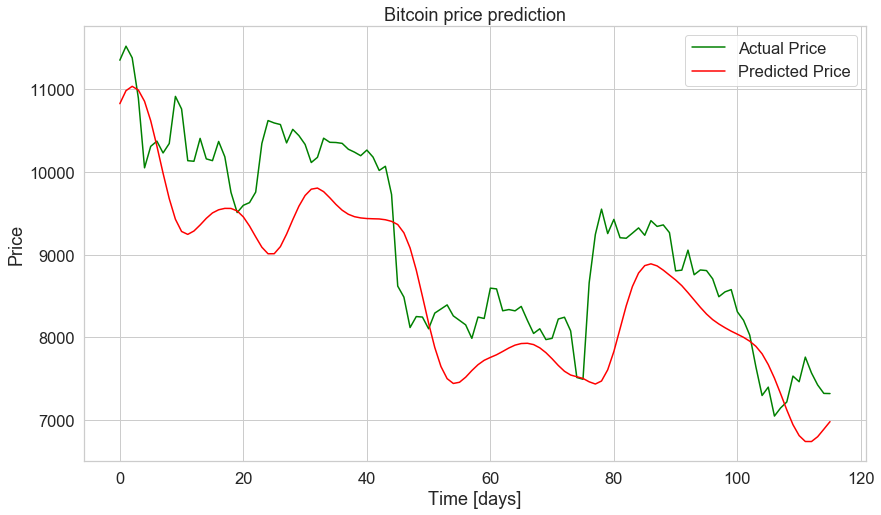

In [138]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

### Epoch 50

In [139]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 9.6730e-04
Epoch 2/50
2196/2196 [==============================] - 21s 10ms/sample - loss: 9.3815e-04
Epoch 3/50
2196/2196 [==============================] - 21s 9ms/sample - loss: 9.2720e-04
Epoch 4/50
2196/2196 [==============================] - 19s 9ms/sample - loss: 9.5619e-04
Epoch 5/50
2196/2196 [==============================] - 22s 10ms/sample - loss: 8.8799e-04
Epoch 6/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 9.3709e-04
Epoch 7/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0011
Epoch 8/50
2196/2196 [==============================] - 22s 10ms/sample - loss: 8.7011e-04
Epoch 9/50
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0011
Epoch 10/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 9.2794e-04
Epoch 11/50
2196/2196 [==============================] - 21s 10ms/sample - loss: 9

In [140]:
model.evaluate(X_test, y_test)

116/116 [==============================] - 0s 3ms/sample - loss: 5.3217e-04


0.0005321728621593451

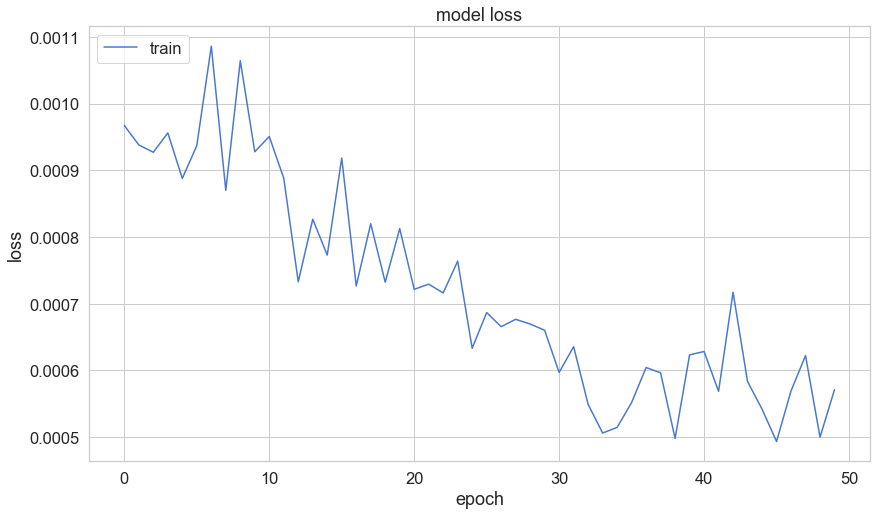

In [141]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

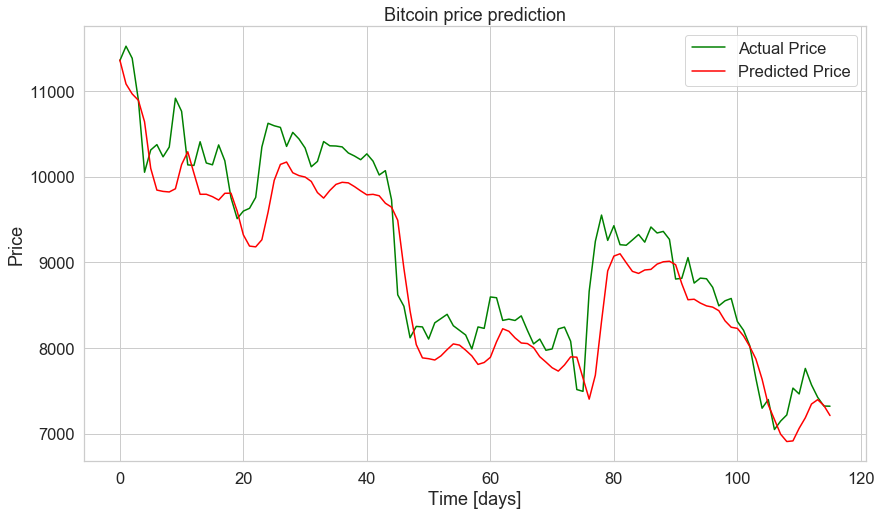

In [142]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## 2. Ethereum

In [143]:
crypto_eth = crypto[crypto['Currency'] == "ethereum"]

In [144]:
crypto_eth = crypto_eth.sort_values('Date')

In [145]:
crypto_eth.shape

(2412, 8)

''

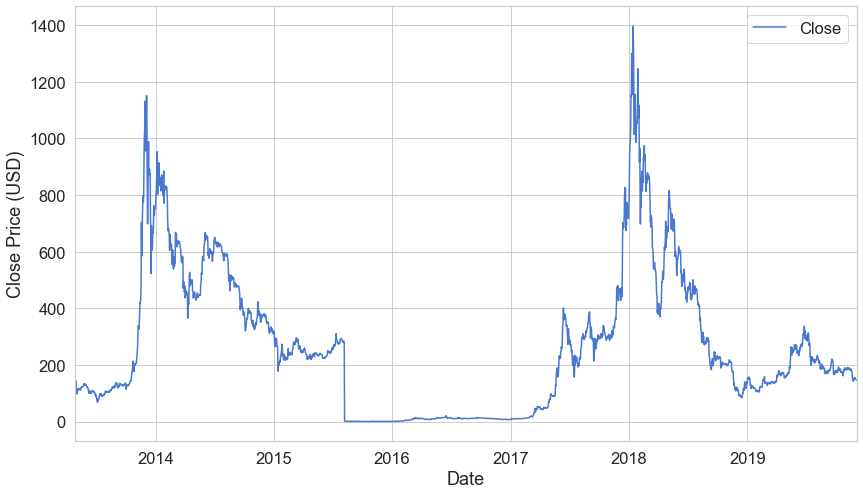

In [146]:
ax = crypto_eth.plot(x='Date', y='Close')
ax.set_xlabel("Date")
ax.set_ylabel("Close Price (USD)")
;

In [147]:
scaler = MinMaxScaler()
close_price = crypto_eth.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)

In [148]:
scaled_close

array([[0.09583163],
       [0.1032314 ],
       [0.09926289],
       ...,
       [0.10646924],
       [0.10568127],
       [0.1048145 ]])

In [149]:
np.isnan(scaled_close).any()

False

In [150]:
scaled_close = scaled_close[~np.isnan(scaled_close)]
scaled_close = scaled_close.reshape(-1, 1)
np.isnan(scaled_close).any()

False

### Preprocessing

In [151]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [152]:
X_train.shape

(2196, 99, 1)

In [153]:
y_train.shape

(2196, 1)

In [154]:
X_test.shape

(116, 99, 1)

In [155]:
y_test.shape

(116, 1)

## Model

In [156]:
model = Sequential()
#We add the LSTM layer with the following arguments:
#100 units which is the dimensionality of the output space
#return_sequences=True which determines whether to return the last output in the output sequence,
#or the full sequence
#input_shape as the shape of our training set.
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 1)))

#We add the LSTM layer and later add a few Dropout layers to prevent overfitting. 

model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100))
model.add(Dropout(0.2))
model.add(Dense(units=1))



In [157]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

## Epoch 15

In [158]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=15, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/15
2196/2196 [==============================] - 25s 11ms/sample - loss: 0.0102
Epoch 2/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0031
Epoch 3/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0027
Epoch 4/15
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0024
Epoch 5/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0023
Epoch 6/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0023
Epoch 7/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0019
Epoch 8/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0019
Epoch 9/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0022
Epoch 10/15
2196/2196 [==============================] - 21s 9ms/sample - loss: 0.0022
Epoch 11/15
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0016
Epoch 12/15
2196/2196 [======

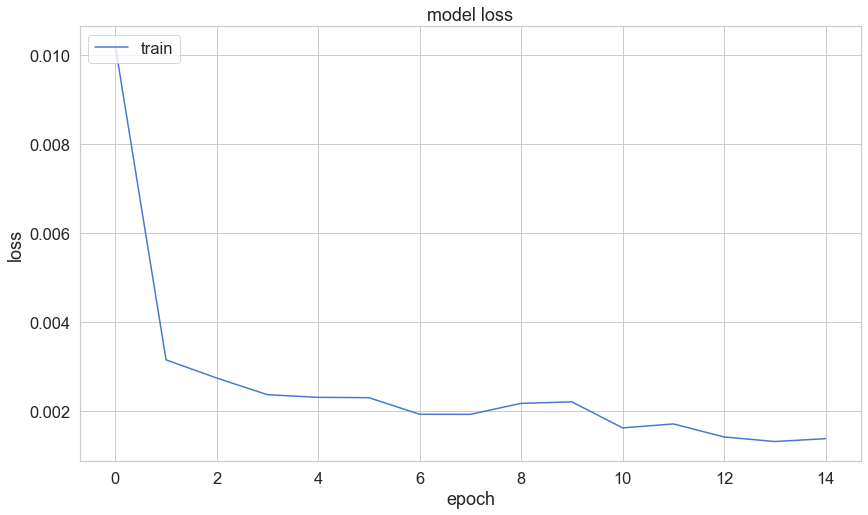

In [159]:

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

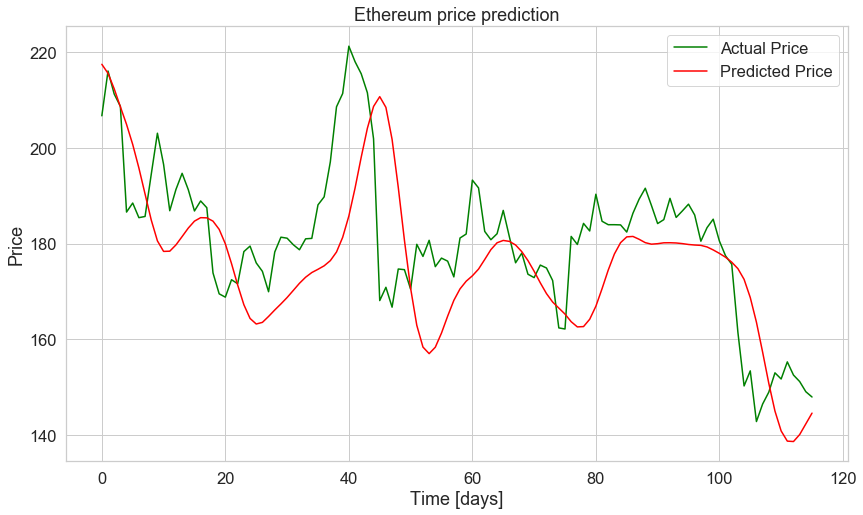

In [160]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

## Epoch 50

In [161]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE
)

Train on 2196 samples
Epoch 1/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0013
Epoch 2/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0013
Epoch 3/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0012
Epoch 4/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0016
Epoch 5/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0012
Epoch 6/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0012
Epoch 7/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0012
Epoch 8/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0011
Epoch 9/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0012
Epoch 10/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0010
Epoch 11/50
2196/2196 [==============================] - 20s 9ms/sample - loss: 0.0014
Epoch 12/50
2196/2196 [=======

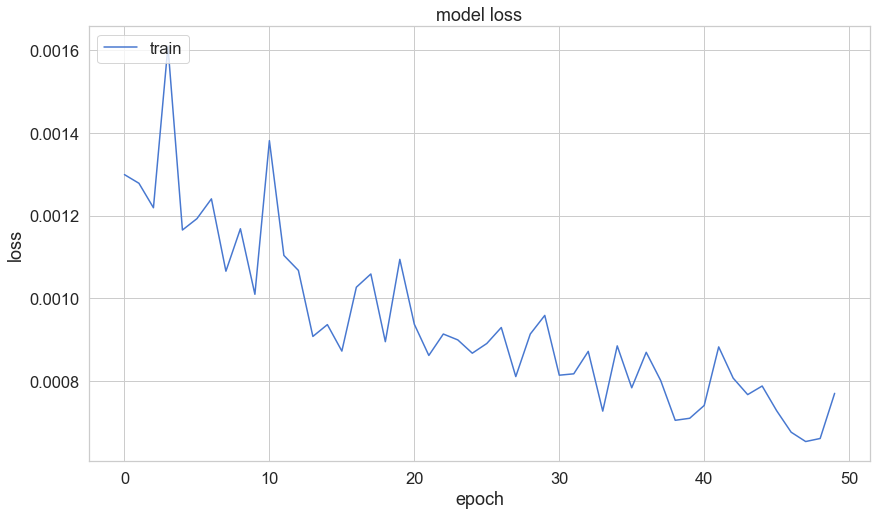

In [162]:

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

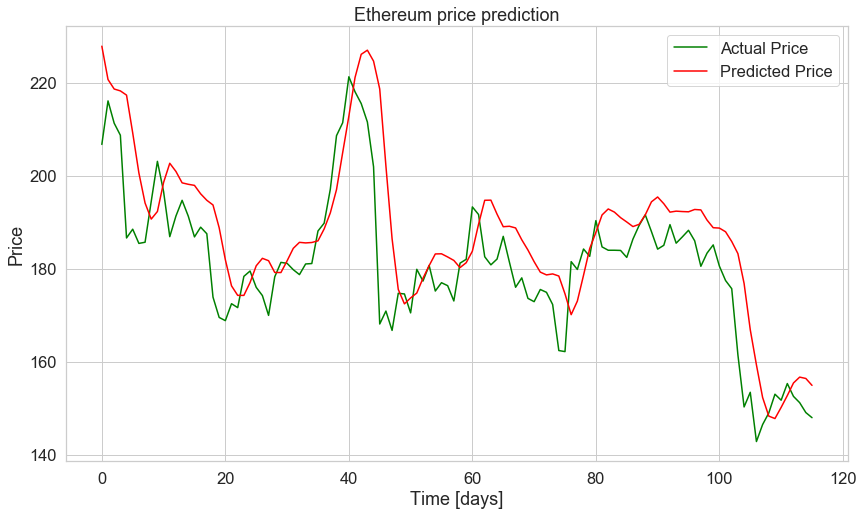

In [163]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Ethereum price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();